## Densely connected networks (DenseNet)
- main diffrence b/w resnet is we concat layers rather than adding them
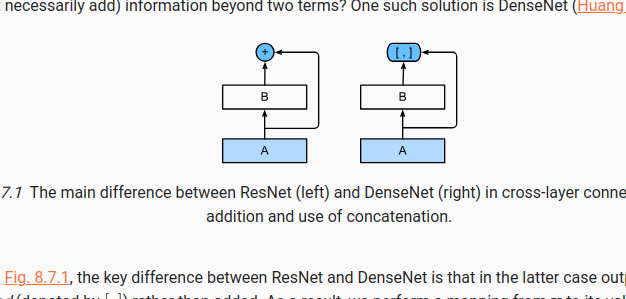
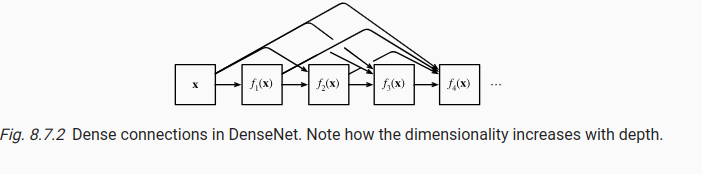
- main component are dense block and transition layers - former controls how i/o is connected and later controls num of channels so not too large
- 


In [3]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

In [5]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

In [6]:
blk = DenseBlock(2, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

/home/athapar/miniconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 23, 8, 8])

In [7]:
# transition layer reduces complexity by using 1x1 conv and half h & w via avg pool and stride of 2
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1, stride=1),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )

In [9]:
blk2 = transition_block(10) 
blk2(Y).shape # reduced output channels to 10 & halves h & w

torch.Size([4, 10, 4, 4])

In [10]:
class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [11]:
@d2l.add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))
    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [ ]:
model = DenseNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)